# 0.0 SOLUTION PLANNING (IOT)

**Input**
1. Business Problem
    - Select the most valuable customers to join a loyalty program (Insiders program).
#
2. Data
    - E-commerce sales over 1 year period.

**Output**

1. The indication of people who will be part of the Insiders program
    - List:          client_id | is_insider |
#
2. Report containing the solutions for the business questions

- Who are eligible to participate the Insiders program?

- How many customers will be part of the group?

- What are the mainly characteristics of there customers?

- What is the % of revenue coming of these customers?

- What's the revenue expectation for this group next month?

- What are the conditions for someone to be eligible for insiders?

- What are the conditions for someone to be removed from insiders?

- What is the guarantee that the Insiders program is best than the remaining base?

- What actions the marketing team can do for increasing the revenue?


#### Tasks

1. **Report with answers**:

- 1. Who are eligible to participate the Insiders program?
    - What is being eligible? What are the most valuable customers?
        - Shopping experience
        - Basket size
        - Higher LTV
        - Higher average ticket
        - Low probability of Churn 
        - Higher shopping probability
        - Low devolution rate
        - Positive reviews        
#
- 2. How many customers will be part of the group?
    - Quantity of customers
    - % of Insiders group

#
- 3. What are the mainly characteristics of there customers?
    - Write customers characteristics:
        - Age
        - Localization
    #
    - Write shopping characteristics:
        - Clustering features
#
- 4. What is the % of revenue coming of these customers?
    - Total Revenue vs Insiders Group Revenue
#
- 5. What's the revenue expectation for this group next month?
    - Insiders group LTV
    - Cohort analysis
#
- 6. What are the conditions for someone to be eligible for insiders?
    - Define the Insiders update periodicity
    - The customer needs to be similar to someone that is present in the group
#
- 7. What are the conditions for someone to be removed from insiders?
    - Define the Insiders update periodicity
    - The customer needs to be non imilar to someone that is present in the group
#
- 8. What is the guarantee that the Insiders program is best than the remaining base?
    - A/B Test
    - Baysean A/B Test
    - Hypothesis test
#
- 9. What actions the marketing team can do for increasing the revenue?
    - Discount
    - New employees
    - New products


## 0.1 Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import re

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import metrics as m
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px

## 0.2 Helper functions

## 0.3 Load dataset

In [54]:
# load data
df_raw = pd.read_csv(r'C:\Users\diego\OneDrive\Área de Trabalho\Portfolio Projects\insiders-clustering\data\Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)



In [55]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DATA DESCRIPTION

In [56]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [57]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [58]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [59]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [60]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [61]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1 - df1.shape[0]/df_raw.shape[0])*100))

Removed data: 24.93%


In [62]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change dtypes

In [63]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive statistics

In [64]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [65]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
quantity,12.061303,5.00,248.693370,-80995.0,80995.0,0.182663,94317.563673
unit_price,3.460471,1.95,69.315162,0.0,38970.0,452.219019,246924.542988
customer_id,15287.690570,15152.00,1713.600303,12346.0,18287.0,0.029835,-1.179982


<font color='red'>**Some points:**</font>
- The minimum of 'quantity' is a negative value
- The minimum 'unit_price' is zero


### 1.7.2 Categorical attributes

In [67]:
# invoice_no

# cat_attributes['invoice_no'].astype(np.int64)
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())


3654

In [75]:
# at leat one string at stock code
one_string = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x ))), 'stock_code'])
print(one_string)

# only string
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x ))), 'stock_code'].unique()

35809


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 VARIABLES FILTERING

In [121]:
df2 = df1.copy()

In [122]:
# ==== Numerical Attributes ====
# unit price > 0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK'])]

# quantity - Negative numbers will be assumed as product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]


# 3.0 FEATURE ENGINEERING

In [132]:
df3 = df2.copy()

## 3.1 Feature creation

In [133]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code','description', 
                  'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [134]:
# Gross Revenue: quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()


C:\Users\diego\AppData\Local\Temp\ipykernel_15384\4214480837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

In [135]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']]
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()



customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [136]:
# Frequency
df_freq = df2_purchase[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [137]:
# Avg ticket
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [138]:
# Number of returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()


customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [147]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,372.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [139]:
# # Gross Revenue: quantity * price
# df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# # Monetary
# df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# # Recency - Last day purchase
# df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
# df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency[['customer_id','recency_days']]
# df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# # Frequency
# df_freq = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# # Avg ticket
# df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
# df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

# 4.0 EXPLORATORY DATA ANALYSIS

In [151]:
df4 = df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [179]:
df5 = df4.copy()

In [180]:
from sklearn import preprocessing as pp

In [181]:
#mms= pp.StandardScaler()
mms = pp.MinMaxScaler()

df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
df5['invoice_no'] = mms.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
df5['returns'] = mms.fit_transform(df5[['returns']])

# 6.0 FEATURE SELECTION

In [182]:
df6 = df5.copy()

#  7.0 HYPERPARAMETER FINE-TUNING

In [183]:
X = df6.drop(columns=['customer_id'])

In [184]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

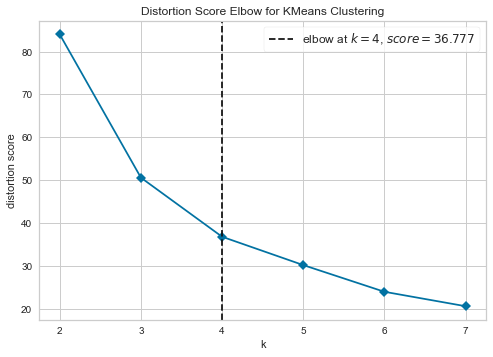

In [185]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette score

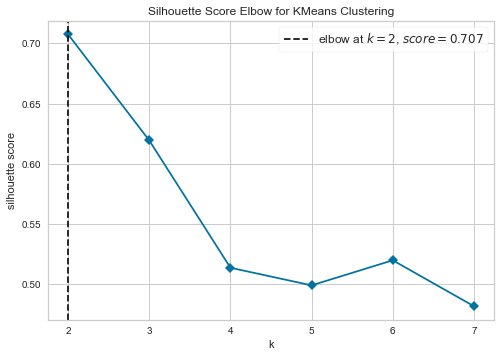

In [186]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Silhouette analysis

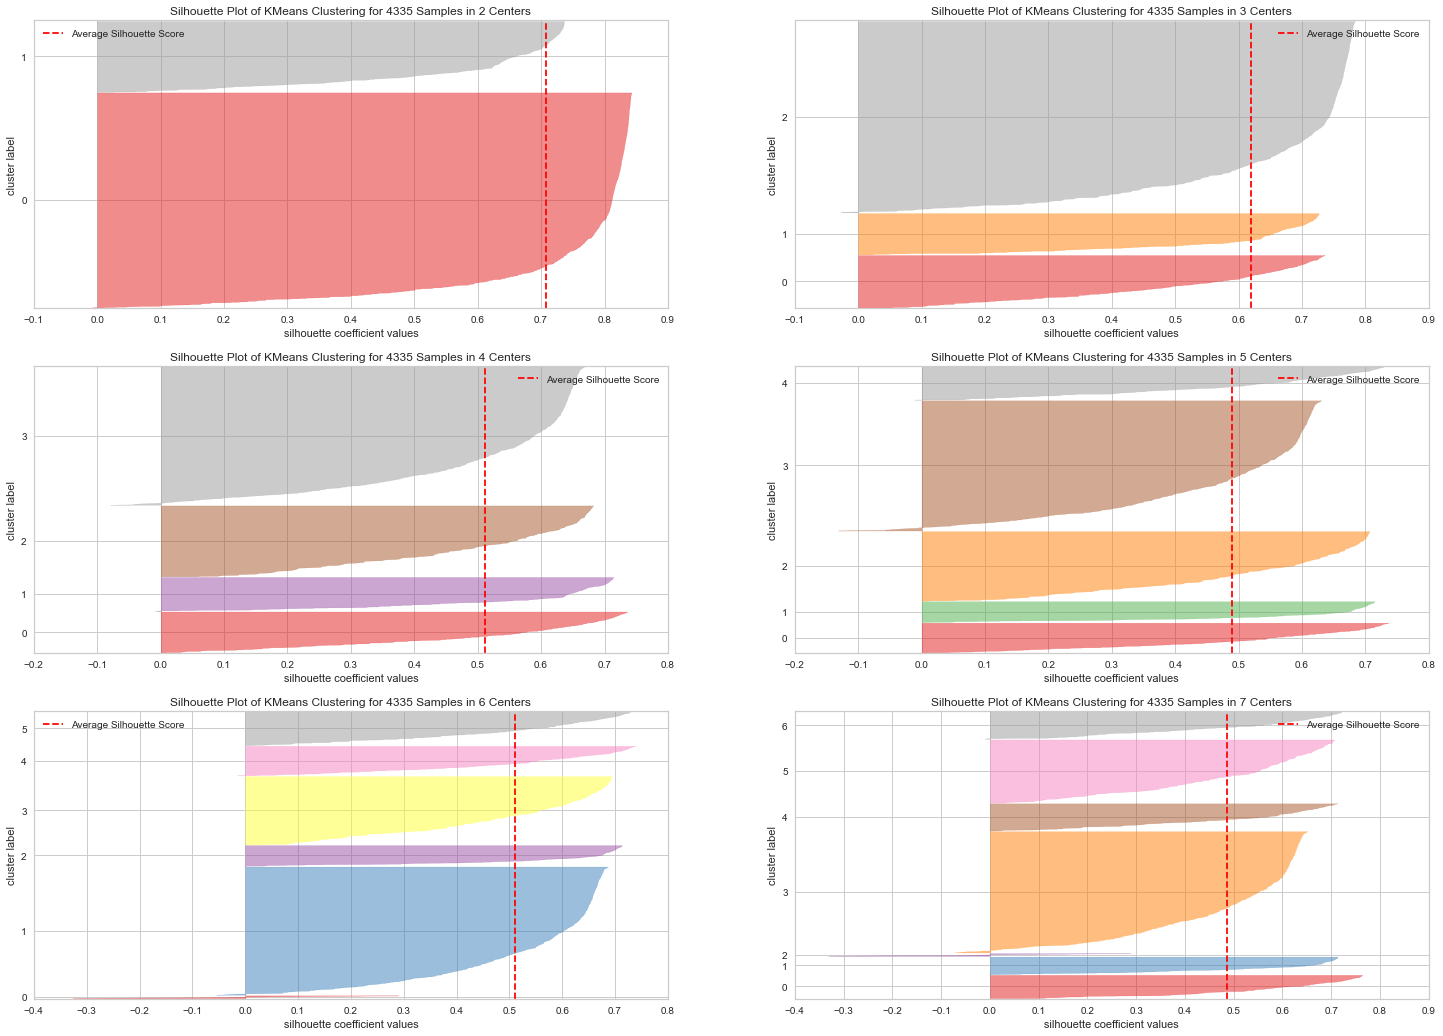

In [187]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)

    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 MODEL TRAINING

## 8.1 K-Means

In [188]:
# model definition
k = 6
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [189]:
## WSS (Within-cluster Sum of Square)
print('wss value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'. format(m.silhouette_score(X, labels, metric='euclidean')))


wss value: 23.92647148547259
SS value: 0.5111261298485545


# 9.0 CLUSTER ANALYSIS

In [190]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization inspection

c:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


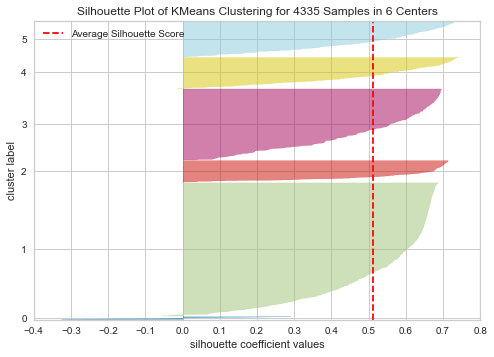

In [191]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

In [192]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.022222,2
1,13047,0.011567,0.150134,0.039024,0.000218,0.155556,3
2,12583,0.024009,0.005362,0.068293,0.000347,0.044444,1
3,13748,0.003384,0.254692,0.019512,0.000412,0.000000,3
4,15100,0.003125,0.892761,0.009756,0.003756,0.066667,2


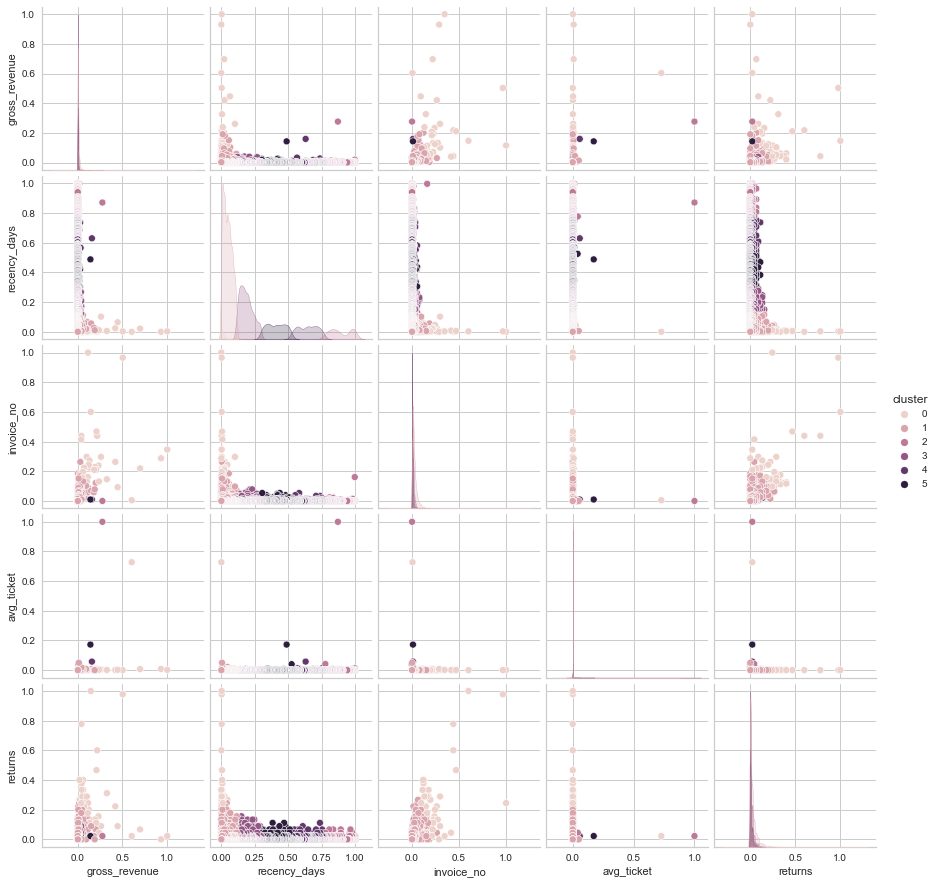

In [193]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

In [194]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,0.019301,0.997319,0.160976,0.000208,0.022222
1,0.011567,0.150134,0.039024,0.000218,0.155556
2,0.024009,0.005362,0.068293,0.000347,0.044444
3,0.003384,0.254692,0.019512,0.000412,0.000000
4,0.003125,0.892761,0.009756,0.003756,0.066667


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

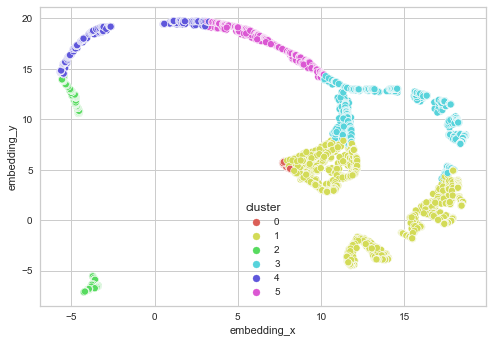

In [197]:
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors= len(df_viz['cluster'].unique())),
                data= df_viz)

The clusterization showed worse in its metrics

## 9.2 Cluster profile

In [196]:
# number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg invoice no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,43,0.991926,0.199539,0.012220,0.250482,0.018358
1,1,1962,45.259516,0.008056,0.046504,0.022829,0.000356
2,2,318,7.335640,0.002266,0.890249,0.001641,0.003715
3,3,1046,24.129181,0.003701,0.186442,0.008236,0.000350
4,4,454,10.472895,0.002086,0.645144,0.002407,0.000572
5,5,512,11.810842,0.002789,0.408486,0.005659,0.000789


# 10.0 DEPLOY TO PRODUCTION